In [44]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [31]:
# this is the cleaned dataset from previous notebook
current_path = os.getcwd()
inputpath =  "data/credit_card_transactions_processed.csv"

df = pd.read_csv(os.path.join(current_path, '..', inputpath))

In [32]:
categorical_cols = ['merchant','category','gender','city','state', 'job']
numerical_cols  = ['amt','age','distance_km']
X = pd.DataFrame(df[categorical_cols + numerical_cols])
y = df.is_fraud

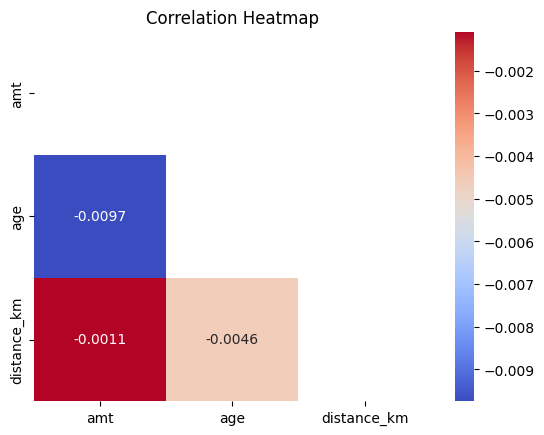

In [33]:
# Calculate and visualize correlations between the features or columns
correlation_matrix = df[numerical_cols].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix))

# Plot the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

 no significant correlation found

In [36]:
# encode categorical col
label_encoder = LabelEncoder()

for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

In [37]:
# downsample
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [38]:
X_res

,merchant,category,gender,city,state,job,amt,age,distance_km
811778,691,2,0,728,4,85,86.19,59.0,85.530738
1101718,390,0,0,486,24,15,85.81,41.0,28.234251
800013,217,4,0,400,38,444,99.30,74.0,91.317056
398945,402,6,0,336,26,489,42.09,47.0,3.697100
207455,175,11,0,409,42,486,4.24,32.0,102.175759
...,...,...,...,...,...,...,...,...,...
1295399,295,11,0,829,9,271,977.01,34.0,93.097732
1295491,571,11,0,829,9,271,1210.91,34.0,84.294502
1295532,622,2,1,209,18,222,10.24,26.0,95.206112
1295666,107,2,0,592,43,115,21.69,51.0,114.493429


In [47]:
# Define a pipeline for Logistic Regression
pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=15000,random_state=42))
])

# Define hyperparameter grid for Logistic Regression
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10]
}

# Create a GridSearchCV object
cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Fit the model to the training data
cv.fit(X_train, y_train)

# Get the best model
best_model = cv.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f"Best Model Parameters: {cv.best_params_}\n")
print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n {conf_matrix}\n")
print(f"Classification Report:\n {class_report}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Best Model Parameters: {'classifier__C': 10}

Accuracy: 0.8541458541458542

Confusion Matrix:
 [[1423   84]
 [ 354 1142]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.87      1507
           1       0.93      0.76      0.84      1496

    accuracy                           0.85      3003
   macro avg       0.87      0.85      0.85      3003
weighted avg       0.87      0.85      0.85      3003

ROC-AUC Score: 0.8531


In [49]:
# Define a pipeline for Logistic Regression
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for Logistic Regression
param_grid = {'max_depth': [2,3,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [50, 75, 100, 200]
             } 
# Create a GridSearchCV object
cv = GridSearchCV(rf, param_grid, cv=5,  scoring='roc_auc')

# Fit the model to the training data
cv.fit(X_train, y_train)

# Get the best model
best_model = cv.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f"Best Model Parameters: {cv.best_params_}\n")
print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n {conf_matrix}\n")
print(f"Classification Report:\n {class_report}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Best Model Parameters: {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}

Accuracy: 0.961038961038961

Confusion Matrix:
 [[1441   66]
 [  51 1445]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      1507
           1       0.96      0.97      0.96      1496

    accuracy                           0.96      3003
   macro avg       0.96      0.96      0.96      3003
weighted avg       0.96      0.96      0.96      3003

ROC-AUC Score: 0.9936
